In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jupyter/.fastai/data/movie_lens_sample')

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/movie_lens_sample/ratings.csv')]

In [5]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [ ]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [ ]:
learn.fit_one_cycle(3, 5e-3)

Total time: 00:04
epoch  train_loss  valid_loss
1      1.600185    0.962681    (00:01)
2      0.851333    0.678732    (00:01)
3      0.660136    0.666290    (00:01)



## Movielens Latest

Let's try with the small latest Movielens dataset, available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [9]:
path=Path('data/movielens/ml-latest-small')

In [13]:
ratings = pd.read_csv(path/'ratings.csv', delimiter=',')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [17]:
movies = pd.read_csv(path/'movies.csv',  delimiter=',')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
len(ratings)

100836

In [20]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [21]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [22]:
data.show_batch()

userId,title,target
1,American Beauty (1999),5.0
45,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),4.0
567,Boudu Saved From Drowning (Boudu sauvé des eaux) (1932),0.5
7,"Aviator, The (2004)",3.5
96,Ghostbusters (a.k.a. Ghost Busters) (1984),5.0
156,Moonstruck (1987),4.0
414,Who Killed the Electric Car? (2006),3.0
463,Braveheart (1995),4.5


### Minimum rating is .5 and max is 5 in this data. Want to make our min a bit lower and our max a bit higher to allow for predictions of the actual min and max in the data (since sigmoid asymptotes)

In [23]:
y_range = [0,5.5]

In [24]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


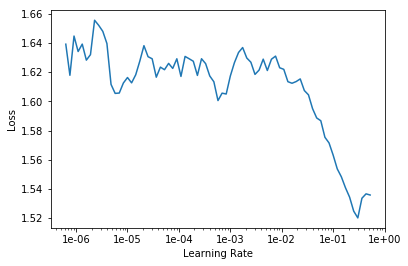

In [25]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [26]:
learn.fit_one_cycle(5, 2e-1)

Total time: 00:39
epoch  train_loss  valid_loss
1      2.870139    2.887047    (00:07)
2      3.623690    3.378773    (00:07)
3      2.747653    2.677819    (00:07)
4      1.226275    1.137192    (00:07)
5      0.772261    0.755240    (00:07)



In [27]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the OLD/ORIGINAL dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`. We are using MSE above in valid_loss.

## Interpretation

### Setup

In [28]:
learn.load('dotprod');

In [29]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(611, 40)
  (i_weight): Embedding(9352, 40)
  (u_bias): Embedding(611, 1)
  (i_bias): Embedding(9352, 1)
)

### Find the movies rated most times

In [30]:
g = rating_movie.groupby(title)['rating'].count()

In [31]:
g.head(5)

title
'71 (2014)                                 1
'Hellboy': The Seeds of Creation (2004)    1
'Round Midnight (1986)                     2
'Salem's Lot (2004)                        1
'Til There Was You (1997)                  2
Name: rating, dtype: int64

In [32]:
top_movies = g.sort_values(ascending=False).index.values[:1000]

In [33]:
top_movies[:10]

array(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)', 'Pulp Fiction (1994)',
       'Silence of the Lambs, The (1991)', 'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)', 'Terminator 2: Judgment Day (1991)', "Schindler's List (1993)"],
      dtype=object)

### Movie bias

### It's interesting to look at movie bias since can see what is particular about a movie. A movie could have a better than average rating because anime fans rate anime highly. When bias is low, rating is lower than expected given features of movie (actors, genre, etc.). When bias is high, rating is higher than expected given features of movie.

In [35]:
# we say is_item=True to pull the bias for the movies rather than the users

movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [36]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
mean_ratings.head(5)

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

In [37]:
movie_biases = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [39]:
movie_biases[:10]

[(tensor(0.6869), 'Forrest Gump (1994)', 4.164133738601824),
 (tensor(0.8814), 'Shawshank Redemption, The (1994)', 4.429022082018927),
 (tensor(0.7085), 'Pulp Fiction (1994)', 4.197068403908795),
 (tensor(0.6549), 'Silence of the Lambs, The (1991)', 4.161290322580645),
 (tensor(0.6646), 'Matrix, The (1999)', 4.192446043165468),
 (tensor(0.6743),
  'Star Wars: Episode IV - A New Hope (1977)',
  4.231075697211155),
 (tensor(0.3412), 'Jurassic Park (1993)', 3.75),
 (tensor(0.5920), 'Braveheart (1995)', 4.031645569620253),
 (tensor(0.5197), 'Terminator 2: Judgment Day (1991)', 3.970982142857143),
 (tensor(0.7627), "Schindler's List (1993)", 4.225)]

In [40]:
item0 = lambda o:o[0]

### Let's look at movies with the lowest bias

In [41]:
sorted(movie_biases, key=item0)[:15]

[(tensor(-0.5780), 'Batman & Robin (1997)', 2.2142857142857144),
 (tensor(-0.5302), 'Coneheads (1993)', 2.4206349206349205),
 (tensor(-0.5151), 'Anaconda (1997)', 1.9259259259259258),
 (tensor(-0.4807), 'Wild Wild West (1999)', 2.207547169811321),
 (tensor(-0.4543), 'Godzilla (1998)', 1.9545454545454546),
 (tensor(-0.3967), 'Lost World: Jurassic Park, The (1997)', 2.753731343283582),
 (tensor(-0.3947), 'Bio-Dome (1996)', 2.532258064516129),
 (tensor(-0.3875),
  "Charlie's Angels: Full Throttle (2003)",
  2.3703703703703702),
 (tensor(-0.3650), 'Showgirls (1995)', 2.4714285714285715),
 (tensor(-0.3374), 'Mortal Kombat (1995)', 2.5434782608695654),
 (tensor(-0.3353), 'Striptease (1996)', 2.4146341463414633),
 (tensor(-0.3351), "Dude, Where's My Car? (2000)", 2.727272727272727),
 (tensor(-0.3089), 'Beverly Hills Cop III (1994)', 2.7203389830508473),
 (tensor(-0.3025), 'Hollow Man (2000)', 2.2948717948717947),
 (tensor(-0.2998), 'Cable Guy, The (1996)', 2.8055555555555554)]

### Let's look at movies with the highest bias

In [43]:
sorted(movie_biases, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.8814), 'Shawshank Redemption, The (1994)', 4.429022082018927),
 (tensor(0.7627), "Schindler's List (1993)", 4.225),
 (tensor(0.7377), 'Godfather, The (1972)', 4.2890625),
 (tensor(0.7253),
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
  4.2075),
 (tensor(0.7147), 'Princess Bride, The (1987)', 4.232394366197183),
 (tensor(0.7095), 'Dark Knight, The (2008)', 4.238255033557047),
 (tensor(0.7085), 'Pulp Fiction (1994)', 4.197068403908795),
 (tensor(0.6869), 'Forrest Gump (1994)', 4.164133738601824),
 (tensor(0.6826),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)',
  4.268041237113402),
 (tensor(0.6817), 'Departed, The (2006)', 4.252336448598131),
 (tensor(0.6743),
  'Star Wars: Episode IV - A New Hope (1977)',
  4.231075697211155),
 (tensor(0.6646), 'Matrix, The (1999)', 4.192446043165468),
 (tensor(0.6628), 'Usual Suspects, The (1995)', 4.237745098039215),
 (tensor(0.6596), "One Flew Over the Cuckoo's Nest (

### Movie weights

In [44]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

### Instead of looking at 40 factors, let's look at fewer columns (3 here) that cover the space of the original matrix

In [45]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [46]:
fac0,fac1,fac2 = movie_pca.t()

In [48]:
fac0[:5]

tensor([ 0.0262, -0.2091, -0.4902, -0.3502, -0.0900])

In [49]:
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

### Fac0 below we see this factor is high for low brow movies and low for high brow movies.

In [50]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8695), 'Jurassic Park III (2001)'),
 (tensor(0.8543), 'Flintstones, The (1994)'),
 (tensor(0.8256), 'Pearl Harbor (2001)'),
 (tensor(0.7603), 'Deep Blue Sea (1999)'),
 (tensor(0.7575), 'Scary Movie (2000)'),
 (tensor(0.7568), 'Finding Forrester (2000)'),
 (tensor(0.7536), 'Tomorrow Never Dies (1997)'),
 (tensor(0.7267), 'Batman & Robin (1997)'),
 (tensor(0.7227), 'Client, The (1994)'),
 (tensor(0.7123), 'Bio-Dome (1996)')]

In [51]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9972), 'Citizen Kane (1941)'),
 (tensor(-0.8370), 'Seven Samurai (Shichinin no samurai) (1954)'),
 (tensor(-0.7738), 'Moonrise Kingdom (2012)'),
 (tensor(-0.7636), 'Clockwork Orange, A (1971)'),
 (tensor(-0.7534), 'This Is Spinal Tap (1984)'),
 (tensor(-0.7358), 'Godfather: Part II, The (1974)'),
 (tensor(-0.7270), 'Big Lebowski, The (1998)'),
 (tensor(-0.7081), 'Ghost in the Shell (Kôkaku kidôtai) (1995)'),
 (tensor(-0.7032), 'Boot, Das (Boat, The) (1981)'),
 (tensor(-0.6949), 'Apocalypse Now (1979)')]

In [52]:
movie_comp2 = [(f, i) for f,i in zip(fac1, top_movies)]

### Fac1 below is picking up on?

In [53]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8162), "Boys Don't Cry (1999)"),
 (tensor(0.6374), 'Witness (1985)'),
 (tensor(0.6245), 'Philadelphia Story, The (1940)'),
 (tensor(0.6134), 'Dog Day Afternoon (1975)'),
 (tensor(0.6119), 'Princess Diaries, The (2001)'),
 (tensor(0.6038), 'Annie Hall (1977)'),
 (tensor(0.5853), 'My Fair Lady (1964)'),
 (tensor(0.5807), 'Up in the Air (2009)'),
 (tensor(0.5615), 'Election (1999)'),
 (tensor(0.5599), 'Iron Man 2 (2010)')]

In [54]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(tensor(-0.8037), 'Hannibal (2001)'),
 (tensor(-0.6965), 'Long Kiss Goodnight, The (1996)'),
 (tensor(-0.6931), 'Almost Famous (2000)'),
 (tensor(-0.6356), 'Transformers (2007)'),
 (tensor(-0.6141), 'First Blood (Rambo: First Blood) (1982)'),
 (tensor(-0.5820), 'Lethal Weapon (1987)'),
 (tensor(-0.5779), 'American History X (1998)'),
 (tensor(-0.5422), 'Sixth Sense, The (1999)'),
 (tensor(-0.5243), 'Superbad (2007)'),
 (tensor(-0.5135), 'Fast Times at Ridgemont High (1982)')]

### Fac2 below is ...?

In [55]:
movie_comp3 = [(f, i) for f,i in zip(fac2, top_movies)]

In [58]:
sorted(movie_comp3, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.9761), 'Interstellar (2014)'),
 (tensor(0.6655), 'Madness of King George, The (1994)'),
 (tensor(0.6106), 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (tensor(0.5395), 'Pearl Harbor (2001)'),
 (tensor(0.5237), 'Inception (2010)'),
 (tensor(0.5205), 'Punch-Drunk Love (2002)'),
 (tensor(0.5105), 'Beetlejuice (1988)'),
 (tensor(0.4982), 'Last of the Mohicans, The (1992)'),
 (tensor(0.4924), 'The Revenant (2015)'),
 (tensor(0.4809), 'Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002)')]

In [59]:
sorted(movie_comp3, key=itemgetter(0))[:10]

[(tensor(-0.6230), 'Miracle on 34th Street (1994)'),
 (tensor(-0.6004), 'Waterboy, The (1998)'),
 (tensor(-0.5539), 'Billy Madison (1995)'),
 (tensor(-0.5507), 'Naked Gun 33 1/3: The Final Insult (1994)'),
 (tensor(-0.5430), 'Pocahontas (1995)'),
 (tensor(-0.5396), 'Peter Pan (1953)'),
 (tensor(-0.5291), 'Toy Story (1995)'),
 (tensor(-0.5283), 'Blair Witch Project, The (1999)'),
 (tensor(-0.5195), 'Kingsman: The Secret Service (2015)'),
 (tensor(-0.4711), "My Best Friend's Wedding (1997)")]

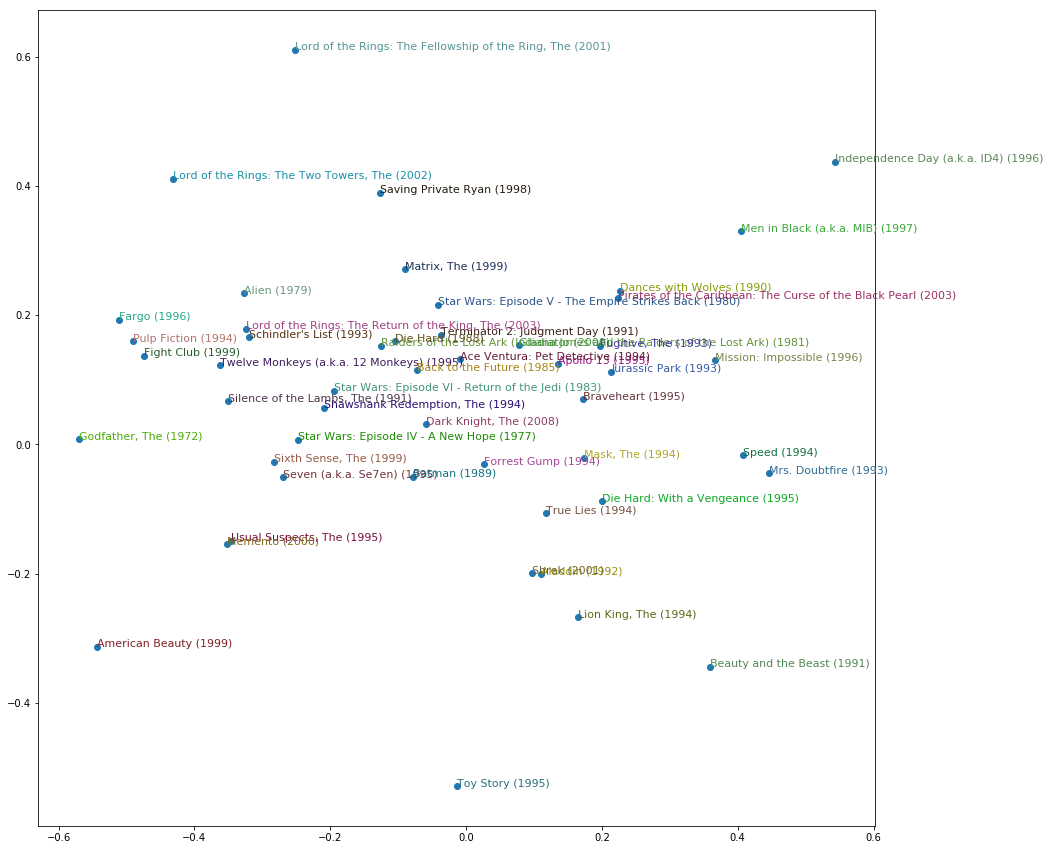

In [60]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()